# 01_eda.ipynb

## Exploratory Data Analysis

**Goal**: Perform comprehensive analysis of the dataset to understand class distribution, bounding box characteristics, and identify potential issues before training.

### What This Notebook Does:
1. Load scan results from `00_setup.ipynb`
2. Build analysis DataFrame with image/object features
3. Generate statistical plots:
   - Class frequency distribution
   - Bounding box area distribution (highlighting small objects)
   - Bounding box width/height distributions
4. Create visualizations:
   - 20 random images with ground truth boxes
   - 10 images with the most objects
   - 10 images with the smallest object instances
5. Provide data quality conclusions

In [1]:
# ============================================================================
# CONFIGURATION CELL
# ============================================================================

import os
import sys

# --- Core Settings ---
SEED = 42
IMG_SIZE = 640
BATCH = 16
MODEL = 'yolov8l'
EPOCHS = 100

# --- Path Settings ---
MOUNT_DRIVE = True
DRIVE_PROJECT_PATH = "/content/drive/MyDrive/Autonomous_Driving_Project"

# --- Environment Detection ---
try:
    from google.colab import drive
    IN_COLAB = True
    if MOUNT_DRIVE:
        drive.mount('/content/drive')
        os.chdir(DRIVE_PROJECT_PATH)
        print(f"✅ Colab: Working directory changed to {DRIVE_PROJECT_PATH}")
except ImportError:
    IN_COLAB = False
    if os.path.basename(os.getcwd()) == "notebooks":
        os.chdir("..")
    print(f"✅ Local: Working directory is {os.getcwd()}")

# Project paths
PROJECT_ROOT = "."
DATA_DIR = "data"
RESULTS_DIR = "results"
FIGURES_DIR = "results/figures"

# Ensure directories exist
os.makedirs(FIGURES_DIR, exist_ok=True)

Mounted at /content/drive
✅ Colab: Working directory changed to /content/drive/MyDrive/Autonomous_Driving_Project


In [2]:
# Import required libraries
import json
import pickle
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import cv2
from collections import defaultdict
from pathlib import Path
from tqdm import tqdm

# Set random seeds
random.seed(SEED)
np.random.seed(SEED)

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [3]:
# ============================================================================
# GPU OPTIMIZATION SETTINGS
# ============================================================================
import torch

# Check GPU availability
GPU_AVAILABLE = torch.cuda.is_available()
DEVICE = 'cuda' if GPU_AVAILABLE else 'cpu'

if GPU_AVAILABLE:
    # Print GPU info
    print("\n" + "=" * 60)
    print("GPU CONFIGURATION")
    print("=" * 60)
    print(f"🚀 GPU detected: {torch.cuda.get_device_name(0)}")
    print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"   CUDA Version: {torch.version.cuda}")

    # Memory optimization settings
    torch.backends.cudnn.benchmark = True  # Optimize conv operations
    torch.backends.cuda.matmul.allow_tf32 = True  # Use TF32 for better performance
    torch.backends.cudnn.allow_tf32 = True

    # Set default tensor type to CUDA
    # torch.set_default_tensor_type('torch.cuda.FloatTensor')  # Optional

    print("\n✅ GPU optimizations enabled:")
    print("   - cuDNN benchmark mode: ON")
    print("   - TF32 for matmul: ON")
else:
    print("⚠️  GPU not available. Running on CPU.")
    print("   Consider using Google Colab with GPU runtime.")

print(f"\n📌 Using device: {DEVICE}")


GPU CONFIGURATION
🚀 GPU detected: NVIDIA L4
   VRAM: 23.8 GB
   CUDA Version: 12.6

✅ GPU optimizations enabled:
   - cuDNN benchmark mode: ON
   - TF32 for matmul: ON

📌 Using device: cuda


/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


## 1. Load Data from Setup Notebook

In [4]:
# Load scan report from 00_setup
scan_report_path = 'results/metrics/scan_report.json'
pairs_path = 'results/metrics/image_label_pairs.pkl'

# Check if setup has been run
if not os.path.exists(scan_report_path) or not os.path.exists(pairs_path):
    print("❌ ERROR: Please run 00_setup.ipynb first to generate scan results.")
    raise FileNotFoundError("Run 00_setup.ipynb first!")

# Load scan report
with open(scan_report_path, 'r') as f:
    scan_report = json.load(f)

# Load image-label pairs
with open(pairs_path, 'rb') as f:
    pairs = pickle.load(f)

print("✅ Loaded scan report and image-label pairs")
print(f"   Annotation format: {scan_report['annotation_format']}")
print(f"   Train images: {len(pairs['train'])}")
print(f"   Val images: {len(pairs['val'])}")
print(f"   Relevant classes: {scan_report['relevant_classes']}")

✅ Loaded scan report and image-label pairs
   Annotation format: KITTI
   Train images: 7481
   Val images: 7481
   Relevant classes: ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting']


## 2. Build Analysis DataFrame

Create a comprehensive DataFrame with:
- Image-level features: path, split, dimensions, object count
- Object-level features: class, bounding box dimensions, area, aspect ratio

In [5]:
def parse_kitti_label(label_path):
    """Parse KITTI format label file."""
    objects = []
    try:
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) < 15:
                    continue
                obj = {
                    'class_name': parts[0],
                    'truncation': float(parts[1]),
                    'occlusion': int(float(parts[2])),
                    'bbox': (
                        float(parts[4]),  # x_left
                        float(parts[5]),  # y_top
                        float(parts[6]),  # x_right
                        float(parts[7])   # y_bottom
                    )
                }
                objects.append(obj)
    except Exception as e:
        print(f"Error parsing {label_path}: {e}")
    return objects

def build_analysis_dataframe(pairs_dict):
    """Build comprehensive analysis DataFrame."""
    image_data = []
    object_data = []

    all_pairs = pairs_dict['train'] + pairs_dict['val']

    print("Building analysis DataFrame...")
    for pair in tqdm(all_pairs, desc="Processing images"):
        # Get image dimensions
        img = cv2.imread(pair['image'])
        if img is None:
            continue
        img_h, img_w = img.shape[:2]

        # Parse labels
        objects = parse_kitti_label(pair['label'])

        # Filter out DontCare
        relevant_objects = [o for o in objects if o['class_name'] != 'DontCare']

        # Class counts for this image
        class_counts = defaultdict(int)
        for obj in relevant_objects:
            class_counts[obj['class_name']] += 1

        # Image-level data
        image_data.append({
            'image_path': pair['image'],
            'label_path': pair['label'],
            'base_name': pair['base_name'],
            'split': pair['split'],
            'width': img_w,
            'height': img_h,
            'n_objects': len(relevant_objects),
            'n_cars': class_counts.get('Car', 0),
            'n_pedestrians': class_counts.get('Pedestrian', 0),
            'n_cyclists': class_counts.get('Cyclist', 0),
            'n_trucks': class_counts.get('Truck', 0) + class_counts.get('Van', 0),
            'class_counts_str': str(dict(class_counts))
        })

        # Object-level data
        for obj in relevant_objects:
            x1, y1, x2, y2 = obj['bbox']
            bbox_w = x2 - x1
            bbox_h = y2 - y1
            bbox_area = bbox_w * bbox_h
            aspect_ratio = bbox_w / bbox_h if bbox_h > 0 else 0

            # Normalized values
            bbox_w_norm = bbox_w / img_w
            bbox_h_norm = bbox_h / img_h
            bbox_area_norm = bbox_area / (img_w * img_h)

            object_data.append({
                'image_path': pair['image'],
                'base_name': pair['base_name'],
                'split': pair['split'],
                'class_name': obj['class_name'],
                'truncation': obj['truncation'],
                'occlusion': obj['occlusion'],
                'x1': x1,
                'y1': y1,
                'x2': x2,
                'y2': y2,
                'bbox_w': bbox_w,
                'bbox_h': bbox_h,
                'bbox_area': bbox_area,
                'aspect_ratio': aspect_ratio,
                'bbox_w_norm': bbox_w_norm,
                'bbox_h_norm': bbox_h_norm,
                'bbox_area_norm': bbox_area_norm,
                'img_width': img_w,
                'img_height': img_h
            })

    df_images = pd.DataFrame(image_data)
    df_objects = pd.DataFrame(object_data)

    return df_images, df_objects

# Build DataFrames
df_images, df_objects = build_analysis_dataframe(pairs)

print(f"\n✅ Analysis DataFrames created:")
print(f"   Images DataFrame: {len(df_images)} rows")
print(f"   Objects DataFrame: {len(df_objects)} rows")

Building analysis DataFrame...


Processing images: 100%|██████████| 14962/14962 [9:36:12<00:00,  2.31s/it]



✅ Analysis DataFrames created:
   Images DataFrame: 14962 rows
   Objects DataFrame: 81140 rows


In [6]:
# Display sample data
print("\n📊 Images DataFrame Sample:")
display(df_images.head())

print("\n📊 Objects DataFrame Sample:")
display(df_objects.head())


📊 Images DataFrame Sample:


image_path              label_path base_name  split  \
0  data/images/train/000000.png  data/labels/000000.txt    000000  train   
1  data/images/train/000001.png  data/labels/000001.txt    000001  train   
2  data/images/train/000002.png  data/labels/000002.txt    000002  train   
3  data/images/train/000003.png  data/labels/000003.txt    000003  train   
4  data/images/train/000004.png  data/labels/000004.txt    000004  train   

   width  height  n_objects  n_cars  n_pedestrians  n_cyclists  n_trucks  \
0   1224     370          1       0              1           0         0   
1   1242     375          3       1              0           1         1   
2   1242     375          2       1              0           0         0   
3   1242     375          1       1              0           0         0   
4   1242     375          2       2              0           0         0   

                       class_counts_str  
0                     {'Pedestrian': 1}  
1  {'Truck': 1, 'Car': 1, 'Cyclist': 1}  
2                 {'Misc': 1, 'Car': 1}  
3                            {'Car': 1}  
4                            {'Car': 2}


📊 Objects DataFrame Sample:


image_path base_name  split  class_name  truncation  \
0  data/images/train/000000.png    000000  train  Pedestrian         0.0   
1  data/images/train/000001.png    000001  train       Truck         0.0   
2  data/images/train/000001.png    000001  train         Car         0.0   
3  data/images/train/000001.png    000001  train     Cyclist         0.0   
4  data/images/train/000002.png    000002  train        Misc         0.0   

   occlusion      x1      y1      x2      y2  bbox_w  bbox_h   bbox_area  \
0          0  712.40  143.00  810.73  307.92   98.33  164.92  16216.5836   
1          0  599.41  156.40  629.75  189.25   30.34   32.85    996.6690   
2          0  387.63  181.54  423.81  203.12   36.18   21.58    780.7644   
3          3  676.60  163.95  688.98  193.93   12.38   29.98    371.1524   
4          0  804.79  167.34  995.43  327.94  190.64  160.60  30616.7840   

   aspect_ratio  bbox_w_norm  bbox_h_norm  bbox_area_norm  img_width  \
0      0.596228     0.080335     0.445730        0.035808       1224   
1      0.923592     0.024428     0.087600        0.002140       1242   
2      1.676552     0.029130     0.057547        0.001676       1242   
3      0.412942     0.009968     0.079947        0.000797       1242   
4      1.187049     0.153494     0.428267        0.065737       1242   

   img_height  
0         370  
1         375  
2         375  
3         375  
4         375

In [7]:
# Basic statistics
print("\n" + "=" * 60)
print("DATASET STATISTICS")
print("=" * 60)

print(f"\n📊 Image Statistics:")
print(f"   Total images: {len(df_images)}")
print(f"   Train images: {len(df_images[df_images['split'] == 'train'])}")
print(f"   Val images: {len(df_images[df_images['split'] == 'val'])}")
print(f"   Avg objects per image: {df_images['n_objects'].mean():.2f}")
print(f"   Max objects per image: {df_images['n_objects'].max()}")
print(f"   Images with no objects: {len(df_images[df_images['n_objects'] == 0])}")

print(f"\n📊 Object Statistics:")
print(f"   Total objects: {len(df_objects)}")
print(f"   Unique classes: {df_objects['class_name'].nunique()}")
print(f"   Classes: {df_objects['class_name'].unique().tolist()}")


DATASET STATISTICS

📊 Image Statistics:
   Total images: 14962
   Train images: 7481
   Val images: 7481
   Avg objects per image: 5.42
   Max objects per image: 22
   Images with no objects: 0

📊 Object Statistics:
   Total objects: 81140
   Unique classes: 8
   Classes: ['Pedestrian', 'Truck', 'Car', 'Cyclist', 'Misc', 'Van', 'Tram', 'Person_sitting']


## 3. Required Plots

### 3.1 Class Frequency Distribution

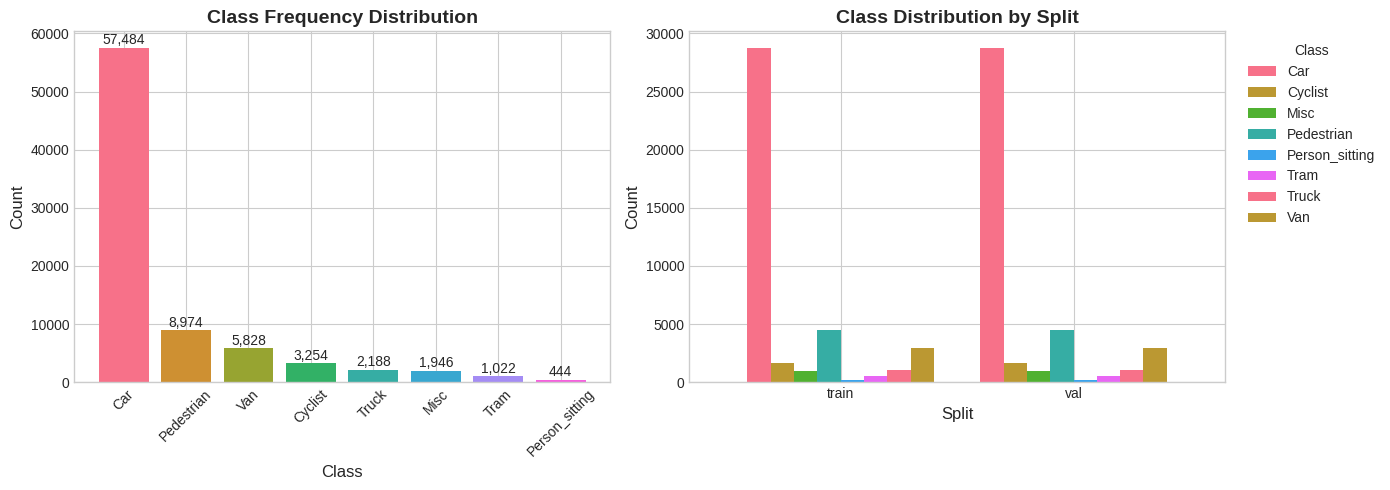


✅ Saved to results/figures/class_distribution.png


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall class distribution
class_counts = df_objects['class_name'].value_counts()
colors = sns.color_palette('husl', n_colors=len(class_counts))

ax1 = axes[0]
bars = ax1.bar(class_counts.index, class_counts.values, color=colors)
ax1.set_xlabel('Class', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Class Frequency Distribution', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, count in zip(bars, class_counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

# Split comparison
ax2 = axes[1]
split_class_counts = df_objects.groupby(['split', 'class_name']).size().unstack(fill_value=0)
split_class_counts.plot(kind='bar', ax=ax2, width=0.8)
ax2.set_xlabel('Split', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Class Distribution by Split', fontsize=14, fontweight='bold')
ax2.legend(title='Class', bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved to {FIGURES_DIR}/class_distribution.png")

### 3.2 Bounding Box Area Distribution (Highlighting Small Objects)

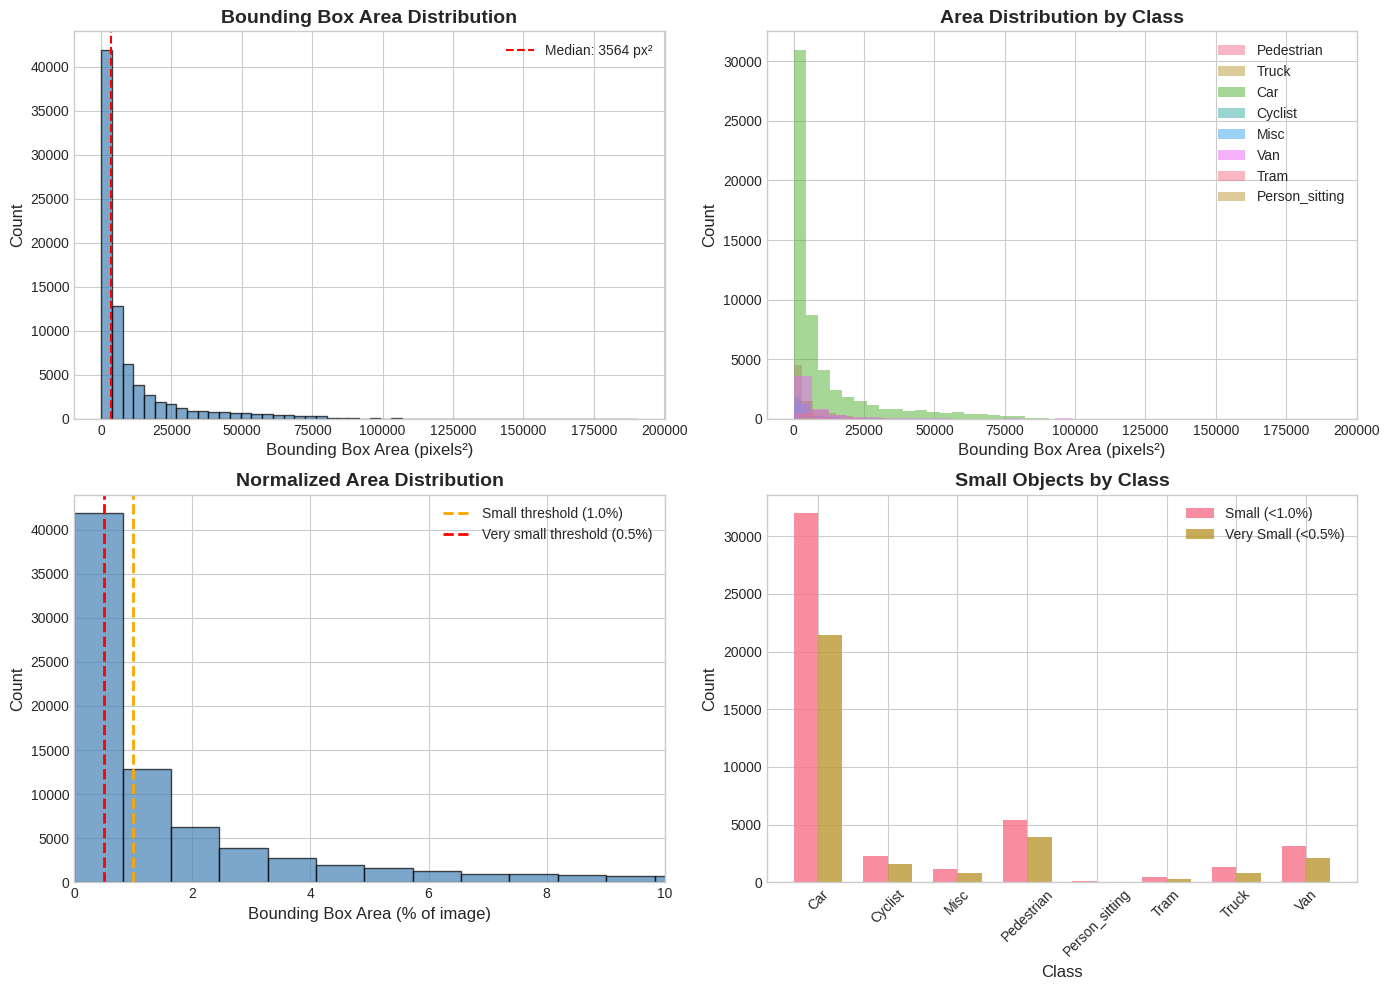


📊 Small Object Statistics:
   Small objects (<1.0% of image): 45,871 (56.5%)
   Very small objects (<0.5% of image): 30,966 (38.2%)

✅ Saved to results/figures/bbox_area_distribution.png


In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Define small object thresholds (percentage of image area)
SMALL_THRESHOLD = 0.01  # 1% of image area
VERY_SMALL_THRESHOLD = 0.005  # 0.5% of image area

# Overall area distribution (log scale)
ax1 = axes[0, 0]
ax1.hist(df_objects['bbox_area'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=df_objects['bbox_area'].median(), color='red', linestyle='--',
            label=f'Median: {df_objects["bbox_area"].median():.0f} px²')
ax1.set_xlabel('Bounding Box Area (pixels²)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Bounding Box Area Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# Area distribution by class
ax2 = axes[0, 1]
for cls in df_objects['class_name'].unique():
    cls_data = df_objects[df_objects['class_name'] == cls]['bbox_area']
    ax2.hist(cls_data, bins=30, alpha=0.5, label=cls)
ax2.set_xlabel('Bounding Box Area (pixels²)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Area Distribution by Class', fontsize=14, fontweight='bold')
ax2.legend()

# Normalized area distribution (highlighting small objects)
ax3 = axes[1, 0]
ax3.hist(df_objects['bbox_area_norm'] * 100, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax3.axvline(x=SMALL_THRESHOLD * 100, color='orange', linestyle='--', linewidth=2,
            label=f'Small threshold ({SMALL_THRESHOLD*100}%)')
ax3.axvline(x=VERY_SMALL_THRESHOLD * 100, color='red', linestyle='--', linewidth=2,
            label=f'Very small threshold ({VERY_SMALL_THRESHOLD*100}%)')
ax3.set_xlabel('Bounding Box Area (% of image)', fontsize=12)
ax3.set_ylabel('Count', fontsize=12)
ax3.set_title('Normalized Area Distribution', fontsize=14, fontweight='bold')
ax3.legend()
ax3.set_xlim(0, 10)  # Focus on smaller objects

# Count of small objects by class
ax4 = axes[1, 1]
small_counts = df_objects[df_objects['bbox_area_norm'] < SMALL_THRESHOLD].groupby('class_name').size()
very_small_counts = df_objects[df_objects['bbox_area_norm'] < VERY_SMALL_THRESHOLD].groupby('class_name').size()

x = range(len(small_counts))
width = 0.35
ax4.bar([i - width/2 for i in x], small_counts.values, width, label=f'Small (<{SMALL_THRESHOLD*100}%)', alpha=0.8)
ax4.bar([i + width/2 for i in x], very_small_counts.reindex(small_counts.index, fill_value=0).values,
        width, label=f'Very Small (<{VERY_SMALL_THRESHOLD*100}%)', alpha=0.8)
ax4.set_xticks(x)
ax4.set_xticklabels(small_counts.index, rotation=45)
ax4.set_xlabel('Class', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Small Objects by Class', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/bbox_area_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
n_small = len(df_objects[df_objects['bbox_area_norm'] < SMALL_THRESHOLD])
n_very_small = len(df_objects[df_objects['bbox_area_norm'] < VERY_SMALL_THRESHOLD])

print(f"\n📊 Small Object Statistics:")
print(f"   Small objects (<{SMALL_THRESHOLD*100}% of image): {n_small:,} ({100*n_small/len(df_objects):.1f}%)")
print(f"   Very small objects (<{VERY_SMALL_THRESHOLD*100}% of image): {n_very_small:,} ({100*n_very_small/len(df_objects):.1f}%)")

print(f"\n✅ Saved to {FIGURES_DIR}/bbox_area_distribution.png")

### 3.3 Bounding Box Width/Height Distributions

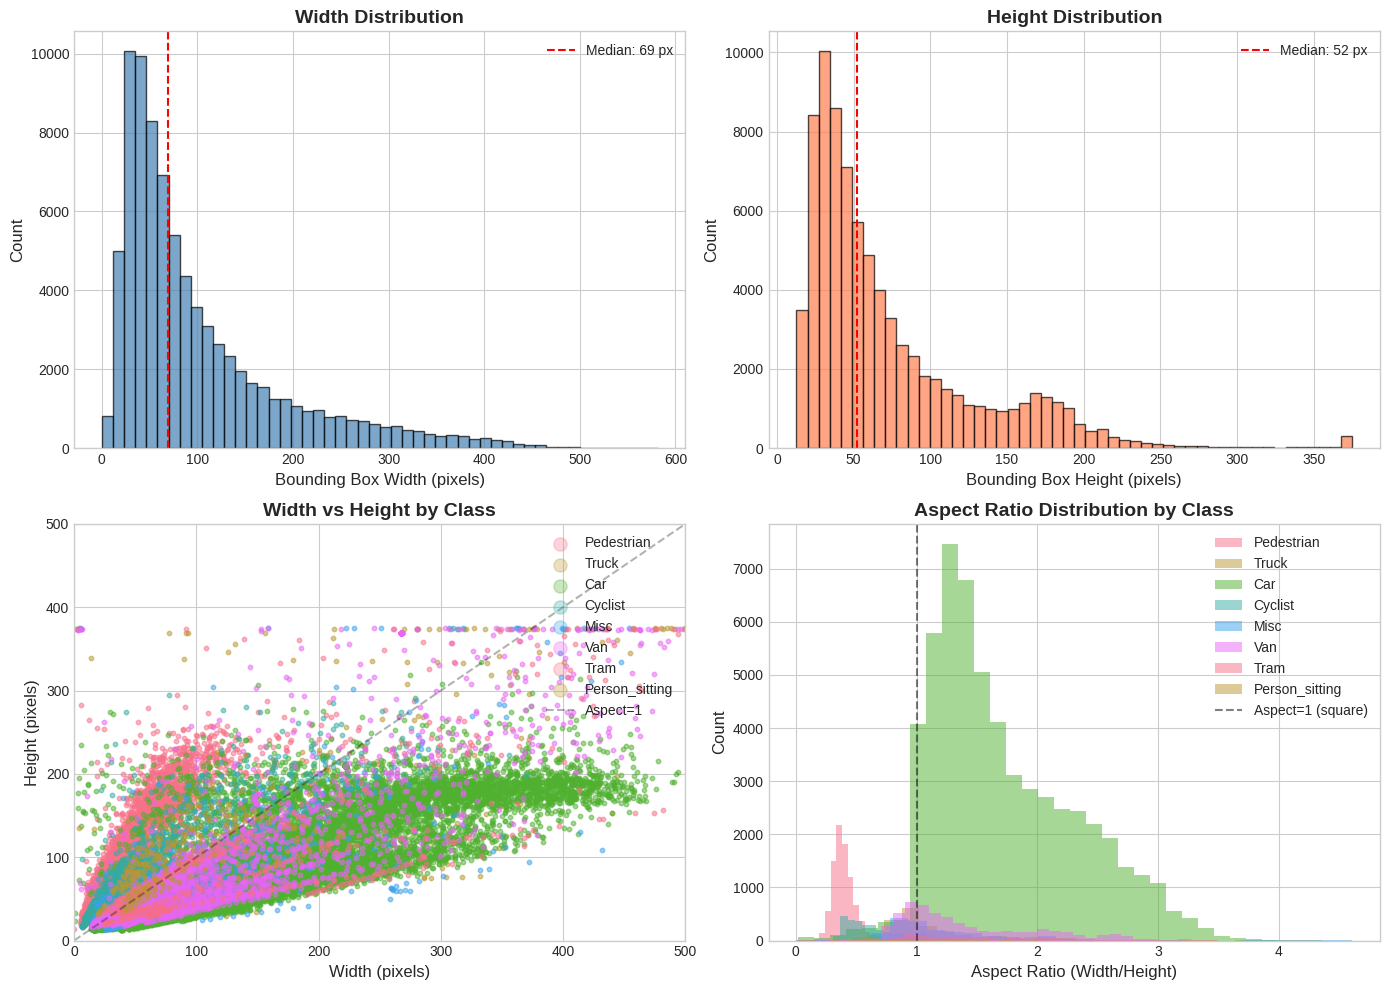


📊 Dimension Statistics:
   Mean width: 101.5 px
   Mean height: 73.4 px
   Mean aspect ratio: 1.48

✅ Saved to results/figures/bbox_dimensions.png


In [10]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Width distribution
ax1 = axes[0, 0]
ax1.hist(df_objects['bbox_w'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=df_objects['bbox_w'].median(), color='red', linestyle='--',
            label=f'Median: {df_objects["bbox_w"].median():.0f} px')
ax1.set_xlabel('Bounding Box Width (pixels)', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Width Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# Height distribution
ax2 = axes[0, 1]
ax2.hist(df_objects['bbox_h'], bins=50, color='coral', alpha=0.7, edgecolor='black')
ax2.axvline(x=df_objects['bbox_h'].median(), color='red', linestyle='--',
            label=f'Median: {df_objects["bbox_h"].median():.0f} px')
ax2.set_xlabel('Bounding Box Height (pixels)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Height Distribution', fontsize=14, fontweight='bold')
ax2.legend()

# Width vs Height scatter
ax3 = axes[1, 0]
for cls in df_objects['class_name'].unique():
    cls_data = df_objects[df_objects['class_name'] == cls]
    ax3.scatter(cls_data['bbox_w'], cls_data['bbox_h'], alpha=0.3, label=cls, s=10)
ax3.plot([0, 500], [0, 500], 'k--', alpha=0.3, label='Aspect=1')
ax3.set_xlabel('Width (pixels)', fontsize=12)
ax3.set_ylabel('Height (pixels)', fontsize=12)
ax3.set_title('Width vs Height by Class', fontsize=14, fontweight='bold')
ax3.legend(loc='upper right', markerscale=3)
ax3.set_xlim(0, 500)
ax3.set_ylim(0, 500)

# Aspect ratio distribution
ax4 = axes[1, 1]
for cls in df_objects['class_name'].unique():
    cls_data = df_objects[df_objects['class_name'] == cls]['aspect_ratio']
    cls_data = cls_data[cls_data < 5]  # Filter extreme values
    ax4.hist(cls_data, bins=30, alpha=0.5, label=cls)
ax4.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='Aspect=1 (square)')
ax4.set_xlabel('Aspect Ratio (Width/Height)', fontsize=12)
ax4.set_ylabel('Count', fontsize=12)
ax4.set_title('Aspect Ratio Distribution by Class', fontsize=14, fontweight='bold')
ax4.legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/bbox_dimensions.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Dimension Statistics:")
print(f"   Mean width: {df_objects['bbox_w'].mean():.1f} px")
print(f"   Mean height: {df_objects['bbox_h'].mean():.1f} px")
print(f"   Mean aspect ratio: {df_objects['aspect_ratio'].mean():.2f}")

print(f"\n✅ Saved to {FIGURES_DIR}/bbox_dimensions.png")

## 4. Required Visualizations

### 4.1 Visualization Helper Functions

In [11]:
# Color map for different classes
CLASS_COLORS = {
    'Car': (0, 255, 0),         # Green
    'Pedestrian': (255, 0, 0),   # Red
    'Cyclist': (0, 0, 255),      # Blue
    'Van': (255, 255, 0),        # Yellow
    'Truck': (255, 0, 255),      # Magenta
    'Person_sitting': (255, 128, 0),  # Orange
    'Tram': (0, 255, 255),       # Cyan
    'Misc': (128, 128, 128),     # Gray
}

def draw_boxes_on_image(img_path, label_path):
    """Draw bounding boxes on an image."""
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros((375, 1242, 3), dtype=np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    objects = parse_kitti_label(label_path)

    for obj in objects:
        if obj['class_name'] == 'DontCare':
            continue

        x1, y1, x2, y2 = [int(v) for v in obj['bbox']]
        color = CLASS_COLORS.get(obj['class_name'], (255, 255, 255))

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

        label = obj['class_name']
        (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
        cv2.rectangle(img, (x1, y1 - 15), (x1 + w + 4, y1), color, -1)
        cv2.putText(img, label, (x1 + 2, y1 - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)

    return img

def visualize_images_grid(image_paths, label_paths, titles, n_cols=5, figsize_per_image=(4, 3), suptitle=None):
    """Create a grid visualization of multiple images with GT boxes."""
    n_images = len(image_paths)
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_image[0]*n_cols, figsize_per_image[1]*n_rows))
    axes = np.array(axes).flatten()

    for i, (img_path, label_path, title) in enumerate(zip(image_paths, label_paths, titles)):
        img = draw_boxes_on_image(img_path, label_path)
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize=9)
        axes[i].axis('off')

    # Hide empty subplots
    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    if suptitle:
        fig.suptitle(suptitle, fontsize=14, fontweight='bold', y=1.02)

    plt.tight_layout()
    return fig

### 4.2 Visualize 20 Random Images with Ground Truth Boxes

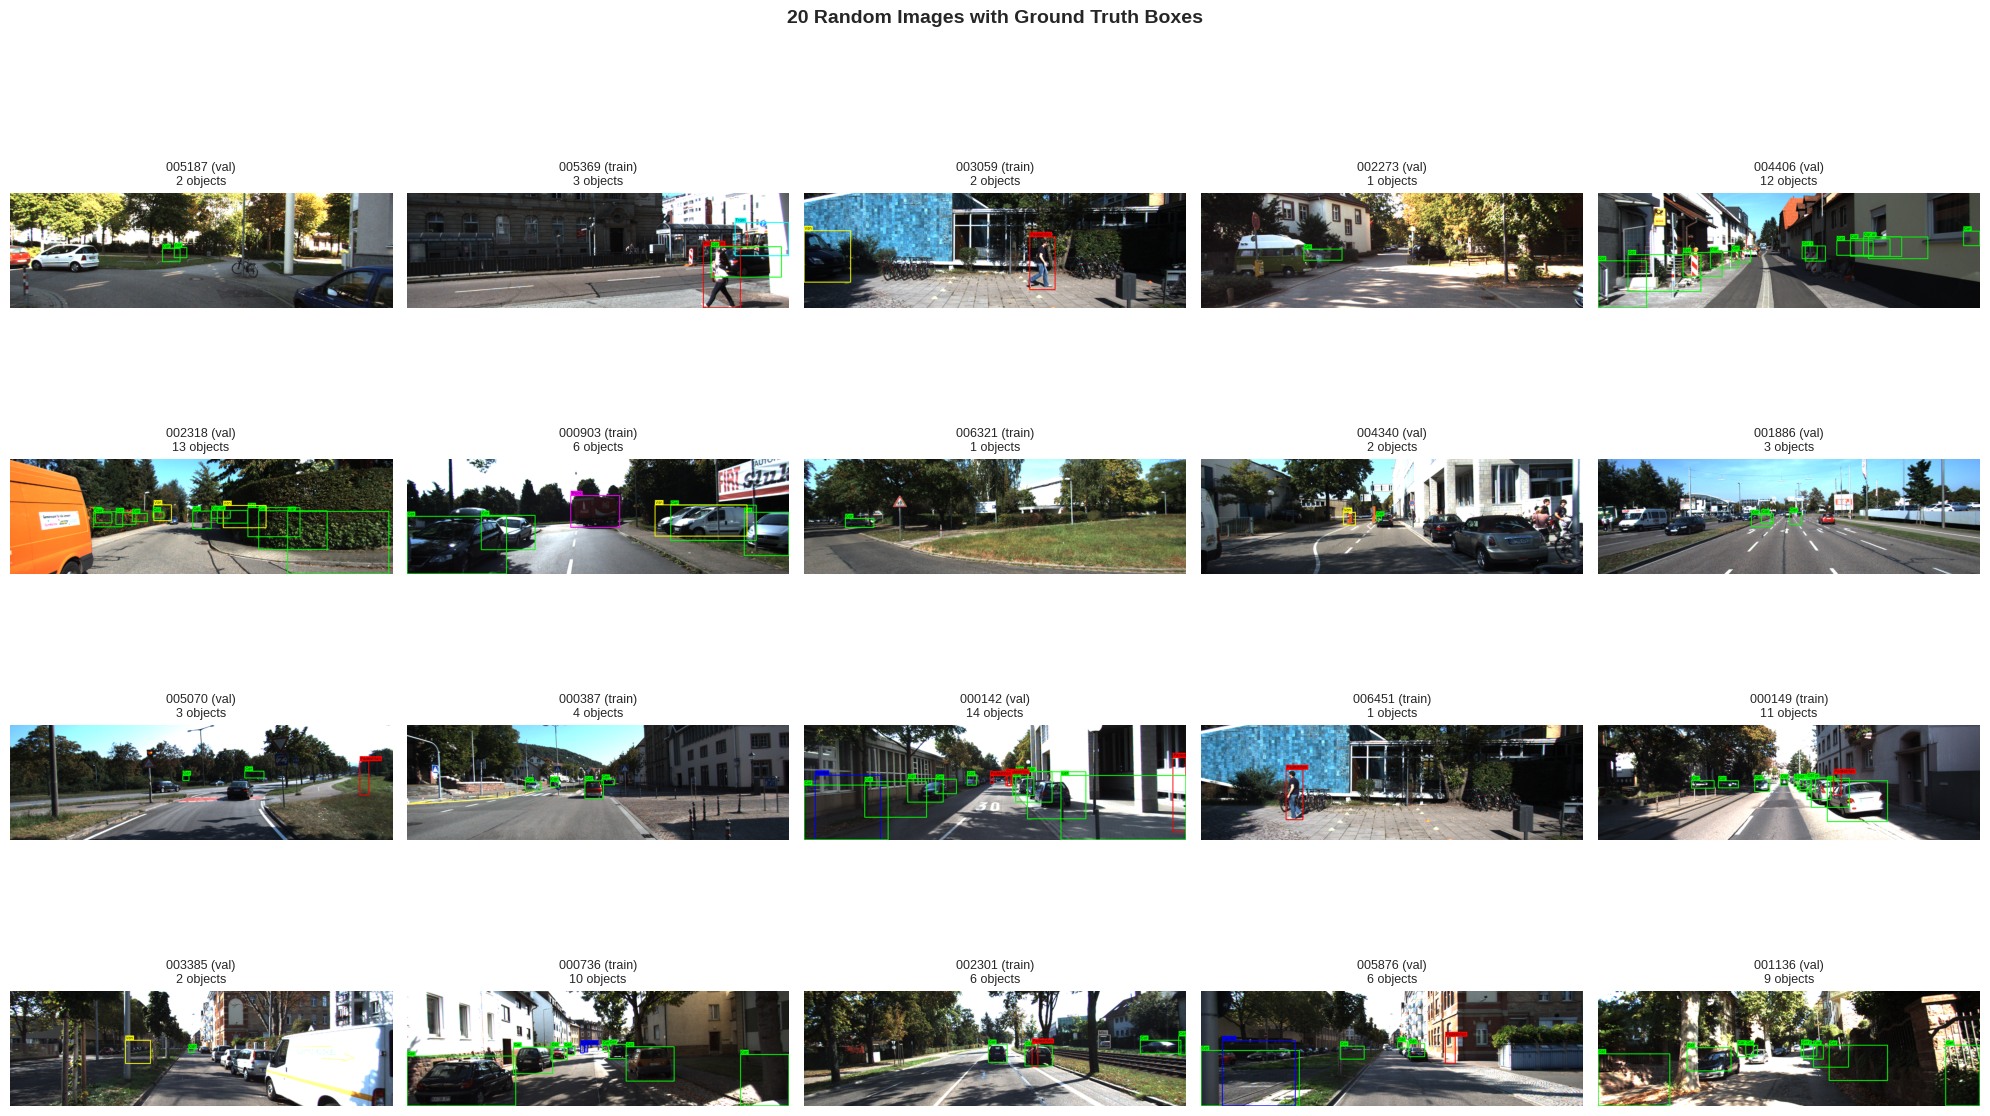


✅ Saved to results/figures/random_20_images.png


In [12]:
# Select 20 random images
random.seed(SEED)
sample_df = df_images.sample(n=min(20, len(df_images)), random_state=SEED)

image_paths = sample_df['image_path'].tolist()
label_paths = sample_df['label_path'].tolist()
titles = [f"{row['base_name']} ({row['split']})\n{row['n_objects']} objects"
          for _, row in sample_df.iterrows()]

fig = visualize_images_grid(
    image_paths, label_paths, titles,
    n_cols=5, figsize_per_image=(4, 3),
    suptitle='20 Random Images with Ground Truth Boxes'
)
plt.savefig(f'{FIGURES_DIR}/random_20_images.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved to {FIGURES_DIR}/random_20_images.png")

### 4.3 Visualize 10 Images with Most Objects

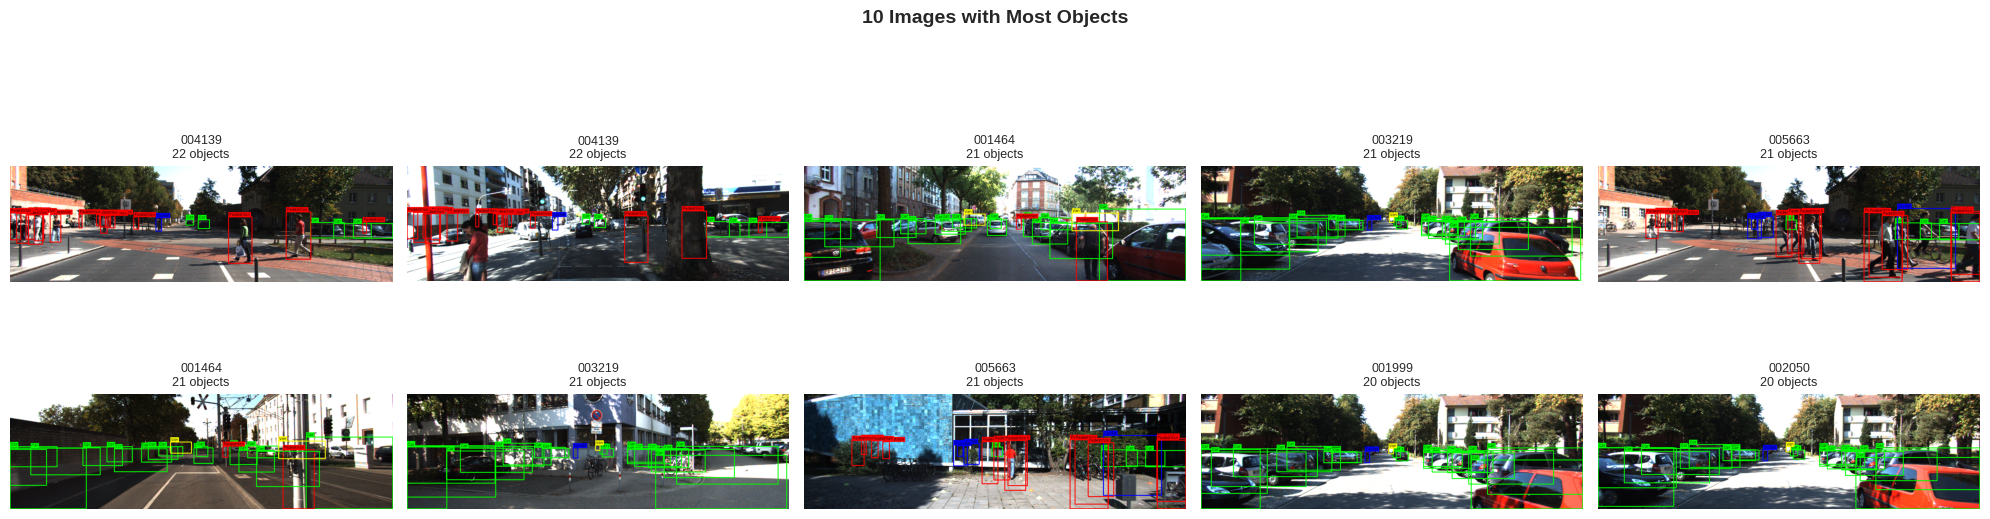


Images with most objects:
  1. 004139: 22 objects
  2. 004139: 22 objects
  3. 001464: 21 objects
  4. 003219: 21 objects
  5. 005663: 21 objects
  6. 001464: 21 objects
  7. 003219: 21 objects
  8. 005663: 21 objects
  9. 001999: 20 objects
  10. 002050: 20 objects

✅ Saved to results/figures/most_objects_10.png


In [13]:
# Get 10 images with most objects
most_objects_df = df_images.nlargest(10, 'n_objects')

image_paths = most_objects_df['image_path'].tolist()
label_paths = most_objects_df['label_path'].tolist()
titles = [f"{row['base_name']}\n{row['n_objects']} objects"
          for _, row in most_objects_df.iterrows()]

fig = visualize_images_grid(
    image_paths, label_paths, titles,
    n_cols=5, figsize_per_image=(4, 3),
    suptitle='10 Images with Most Objects'
)
plt.savefig(f'{FIGURES_DIR}/most_objects_10.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nImages with most objects:")
for i, (_, row) in enumerate(most_objects_df.iterrows(), 1):
    print(f"  {i}. {row['base_name']}: {row['n_objects']} objects")

print(f"\n✅ Saved to {FIGURES_DIR}/most_objects_10.png")

### 4.4 Visualize 10 Images with Smallest Object Instances

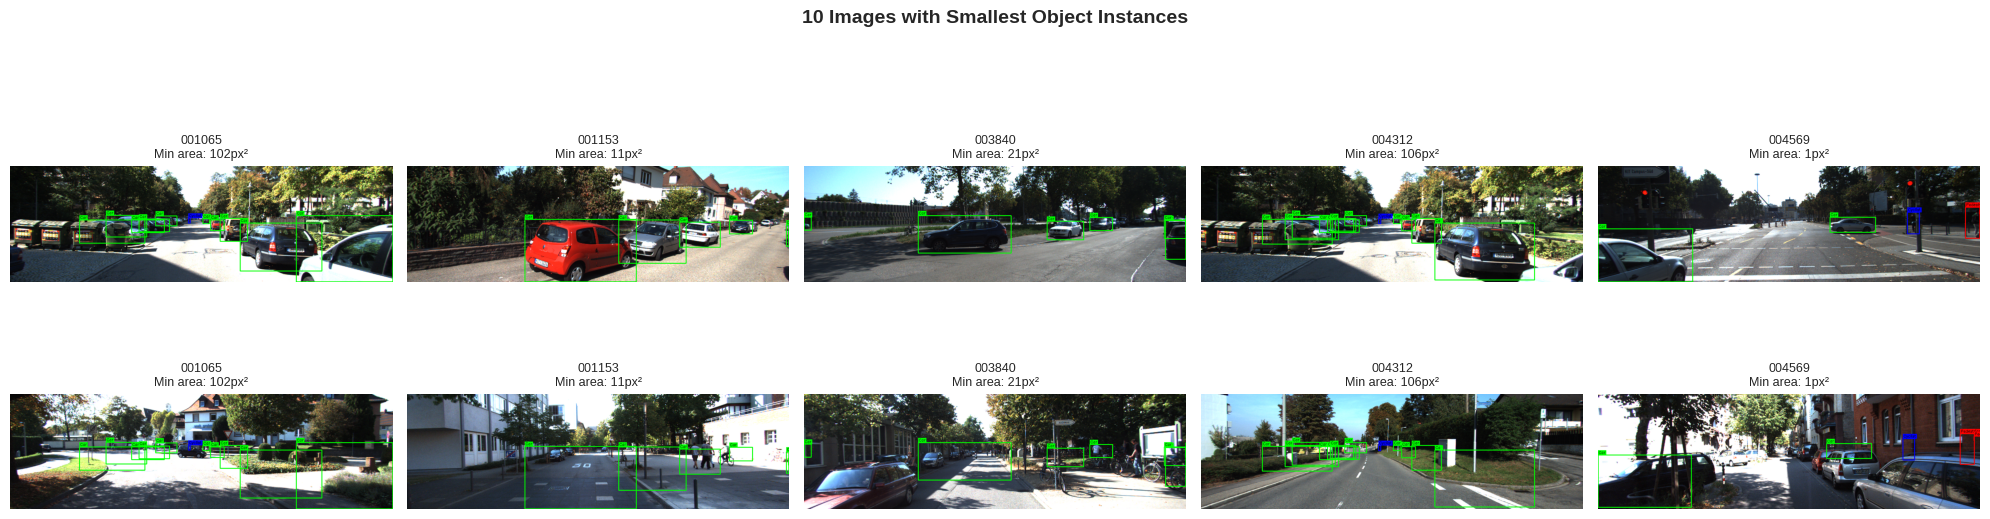


Smallest objects in dataset:
  1. Pedestrian: 1px² (0x14)
  2. Pedestrian: 1px² (0x14)
  3. Car: 11px² (0x23)
  4. Car: 11px² (0x23)
  5. Car: 21px² (1x33)
  6. Car: 21px² (1x33)
  7. Cyclist: 102px² (6x16)
  8. Cyclist: 102px² (6x16)
  9. Cyclist: 106px² (6x17)
  10. Cyclist: 106px² (6x17)

✅ Saved to results/figures/smallest_objects_10.png


In [14]:
# Get images containing the smallest objects
smallest_objects = df_objects.nsmallest(10, 'bbox_area')

# Get unique images containing smallest objects
small_obj_images = smallest_objects['image_path'].unique()[:10]
small_obj_df = df_images[df_images['image_path'].isin(small_obj_images)]

image_paths = small_obj_df['image_path'].tolist()
label_paths = small_obj_df['label_path'].tolist()

# Create titles with smallest object info
titles = []
for img_path in image_paths:
    min_area = df_objects[df_objects['image_path'] == img_path]['bbox_area'].min()
    base = Path(img_path).stem
    titles.append(f"{base}\nMin area: {min_area:.0f}px²")

fig = visualize_images_grid(
    image_paths, label_paths, titles,
    n_cols=5, figsize_per_image=(4, 3),
    suptitle='10 Images with Smallest Object Instances'
)
plt.savefig(f'{FIGURES_DIR}/smallest_objects_10.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nSmallest objects in dataset:")
for i, (_, row) in enumerate(smallest_objects.iterrows(), 1):
    print(f"  {i}. {row['class_name']}: {row['bbox_area']:.0f}px² ({row['bbox_w']:.0f}x{row['bbox_h']:.0f})")

print(f"\n✅ Saved to {FIGURES_DIR}/smallest_objects_10.png")

## 5. Additional Analysis

### 5.1 Occlusion and Truncation Analysis

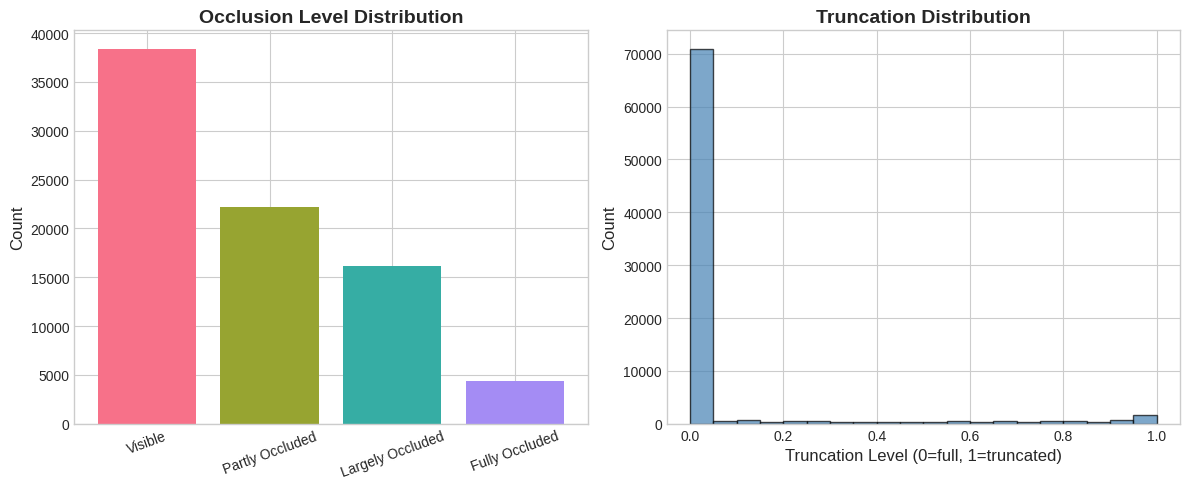


✅ Saved to results/figures/occlusion_truncation.png


In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Occlusion distribution
ax1 = axes[0]
occ_labels = ['Visible', 'Partly Occluded', 'Largely Occluded', 'Fully Occluded']
occ_counts = df_objects['occlusion'].value_counts().sort_index()
ax1.bar(range(len(occ_counts)), occ_counts.values, color=sns.color_palette('husl', 4))
ax1.set_xticks(range(len(occ_counts)))
ax1.set_xticklabels([occ_labels[i] for i in occ_counts.index], rotation=20)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Occlusion Level Distribution', fontsize=14, fontweight='bold')

# Truncation distribution
ax2 = axes[1]
ax2.hist(df_objects['truncation'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Truncation Level (0=full, 1=truncated)', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Truncation Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/occlusion_truncation.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved to {FIGURES_DIR}/occlusion_truncation.png")

### 5.2 Objects per Image Analysis

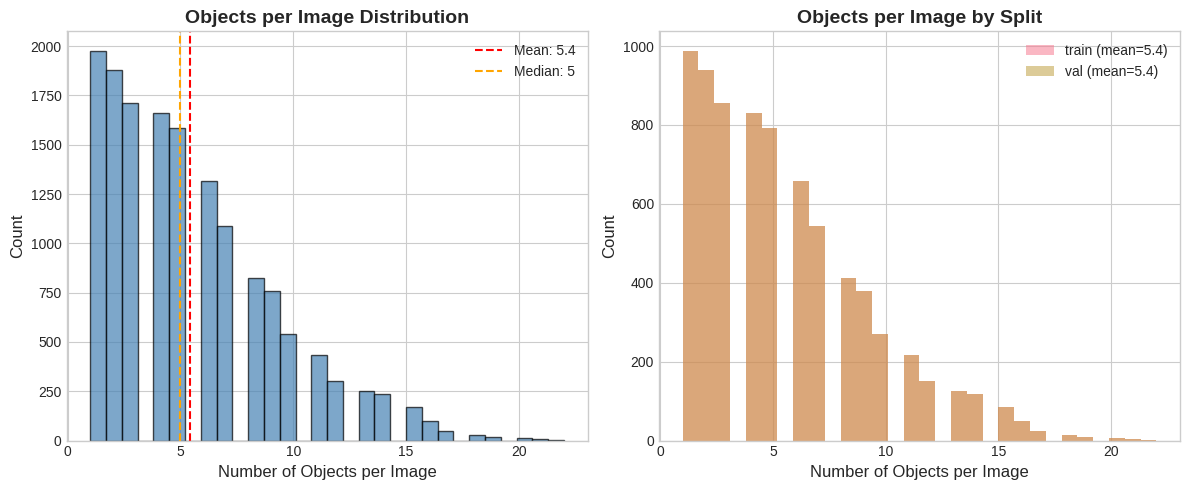


✅ Saved to results/figures/objects_per_image.png


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution
ax1 = axes[0]
ax1.hist(df_images['n_objects'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(x=df_images['n_objects'].mean(), color='red', linestyle='--',
            label=f"Mean: {df_images['n_objects'].mean():.1f}")
ax1.axvline(x=df_images['n_objects'].median(), color='orange', linestyle='--',
            label=f"Median: {df_images['n_objects'].median():.0f}")
ax1.set_xlabel('Number of Objects per Image', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.set_title('Objects per Image Distribution', fontsize=14, fontweight='bold')
ax1.legend()

# By split
ax2 = axes[1]
for split in ['train', 'val']:
    split_data = df_images[df_images['split'] == split]['n_objects']
    ax2.hist(split_data, bins=30, alpha=0.5, label=f"{split} (mean={split_data.mean():.1f})")
ax2.set_xlabel('Number of Objects per Image', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_title('Objects per Image by Split', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{FIGURES_DIR}/objects_per_image.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved to {FIGURES_DIR}/objects_per_image.png")

## 6. Data Quality Conclusions

In [17]:
# Calculate key statistics for conclusions
n_total_objects = len(df_objects)
n_small_objects = len(df_objects[df_objects['bbox_area_norm'] < 0.01])
n_very_small_objects = len(df_objects[df_objects['bbox_area_norm'] < 0.005])
n_occluded = len(df_objects[df_objects['occlusion'] >= 2])
n_truncated = len(df_objects[df_objects['truncation'] > 0.5])
n_empty_images = len(df_images[df_images['n_objects'] == 0])

# Class imbalance
class_counts = df_objects['class_name'].value_counts()
max_class = class_counts.idxmax()
min_class = class_counts.idxmin()
imbalance_ratio = class_counts.max() / class_counts.min()

print("=" * 60)
print("DATA QUALITY CONCLUSIONS")
print("=" * 60)

conclusions = f"""
📊 **Key Findings:**

1. **Class Imbalance**: The dataset has significant class imbalance.
   - Most common: {max_class} ({class_counts.max():,} objects)
   - Least common: {min_class} ({class_counts.min():,} objects)
   - Imbalance ratio: {imbalance_ratio:.1f}x
   → *Implication: May need class weighting or oversampling during training*

2. **Small Objects**: Significant portion of objects are small.
   - Small (<1% of image): {n_small_objects:,} ({100*n_small_objects/n_total_objects:.1f}%)
   - Very small (<0.5% of image): {n_very_small_objects:,} ({100*n_very_small_objects/n_total_objects:.1f}%)
   → *Implication: Model may struggle with small pedestrians/cyclists. Consider using larger input resolution.*

3. **Occlusion/Truncation**: Many objects have visibility challenges.
   - Heavily occluded (level ≥2): {n_occluded:,} ({100*n_occluded/n_total_objects:.1f}%)
   - Significantly truncated (>50%): {n_truncated:,} ({100*n_truncated/n_total_objects:.1f}%)
   → *Implication: Synthetic weather generation must preserve already-difficult objects carefully*

4. **Empty Images**: {n_empty_images} images have no annotated objects.
   → *Implication: These images may still be useful for background/negative samples*

5. **Aspect Ratios**: Objects have diverse aspect ratios.
   - Cars: typically wider (aspect ratio > 1)
   - Pedestrians: typically taller (aspect ratio < 1)
   → *Implication: Anchor boxes should cover diverse ratios*

6. **Dataset Split**: Train/Val split appears balanced.
   - Train: {len(df_images[df_images['split']=='train'])} images
   - Val: {len(df_images[df_images['split']=='val'])} images
   → *Note: Test split will be created from train in notebook 03*
"""

print(conclusions)

# Save conclusions
with open(f'{RESULTS_DIR}/metrics/eda_conclusions.txt', 'w') as f:
    f.write(conclusions)

print(f"\n✅ Conclusions saved to {RESULTS_DIR}/metrics/eda_conclusions.txt")

DATA QUALITY CONCLUSIONS

📊 **Key Findings:**

1. **Class Imbalance**: The dataset has significant class imbalance.
   - Most common: Car (57,484 objects)
   - Least common: Person_sitting (444 objects)
   - Imbalance ratio: 129.5x
   → *Implication: May need class weighting or oversampling during training*

2. **Small Objects**: Significant portion of objects are small.
   - Small (<1% of image): 45,871 (56.5%)
   - Very small (<0.5% of image): 30,966 (38.2%)
   → *Implication: Model may struggle with small pedestrians/cyclists. Consider using larger input resolution.*

3. **Occlusion/Truncation**: Many objects have visibility challenges.
   - Heavily occluded (level ≥2): 20,598 (25.4%)
   - Significantly truncated (>50%): 6,058 (7.5%)
   → *Implication: Synthetic weather generation must preserve already-difficult objects carefully*

4. **Empty Images**: 0 images have no annotated objects.
   → *Implication: These images may still be useful for background/negative samples*

5. **Aspec

In [18]:
# Save analysis DataFrames for use in other notebooks
df_images.to_csv(f'{RESULTS_DIR}/metrics/eda_images.csv', index=False)
df_objects.to_csv(f'{RESULTS_DIR}/metrics/eda_objects.csv', index=False)

print(f"✅ Analysis DataFrames saved:")
print(f"   - {RESULTS_DIR}/metrics/eda_images.csv")
print(f"   - {RESULTS_DIR}/metrics/eda_objects.csv")

✅ Analysis DataFrames saved:
   - results/metrics/eda_images.csv
   - results/metrics/eda_objects.csv


## Summary

This notebook has completed the following EDA tasks:

1. ✅ Loaded scan results from `00_setup.ipynb`
2. ✅ Built comprehensive analysis DataFrame with image and object features
3. ✅ Generated required plots:
   - Class frequency distribution
   - Bounding box area distribution (highlighting small objects)
   - Bounding box width/height distributions
4. ✅ Created required visualizations:
   - 20 random images with ground truth boxes
   - 10 images with the most objects
   - 10 images with the smallest object instances
5. ✅ Provided data quality conclusions with actionable insights

**Generated Files:**
- `results/figures/class_distribution.png`
- `results/figures/bbox_area_distribution.png`
- `results/figures/bbox_dimensions.png`
- `results/figures/random_20_images.png`
- `results/figures/most_objects_10.png`
- `results/figures/smallest_objects_10.png`
- `results/figures/occlusion_truncation.png`
- `results/figures/objects_per_image.png`
- `results/metrics/eda_conclusions.txt`
- `results/metrics/eda_images.csv`
- `results/metrics/eda_objects.csv`

**Next Steps:**
- Run `02_synthetic_generation.ipynb` to generate weather variants
- Run `03_train_eval_compare.ipynb` for model training and evaluation